# MNIST
Try the same tests using 2d MNIST

In [1]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("seaborn-paper")
from matplotlib.pyplot import imshow
from IPython.display import display, HTML

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR
from ipywidgets import FloatProgress

from models.avae2d import AVAE2d, VAE2d
from utils_2d import make_affine2d, TransformedMNIST

%reload_ext autoreload
%autoreload 2
%matplotlib inline
device = "cuda:0"

## Check dataloaders

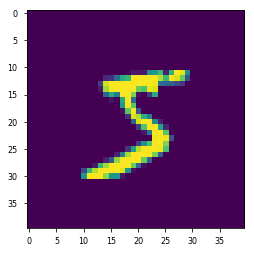

In [2]:
mnist_path = "./data/"
trainset = TransformedMNIST(mnist_path, transform_type="none", train=True)
valset = TransformedMNIST(mnist_path, transform_type="none", train=False)

train_loader = DataLoader(trainset, batch_size=1)
val_loader = DataLoader(valset, batch_size=1)

stuff = next(iter(train_loader))
stuff.keys()
plt.imshow(stuff["data"][0, :, :].squeeze().numpy())

In [3]:
trainset = TransformedMNIST(mnist_path, transform_type="rand_rot", train=True)
train_loader = DataLoader(trainset, batch_size=1)
stuff = next(iter(train_loader))
plt.imshow(stuff["data"][0, :, :].squeeze().numpy())

NotImplementedError: affine_grid only supports 4D and 5D sizes, for 2D and 3D affine transforms, respectively. Got size torch.Size([1, 40, 40]).

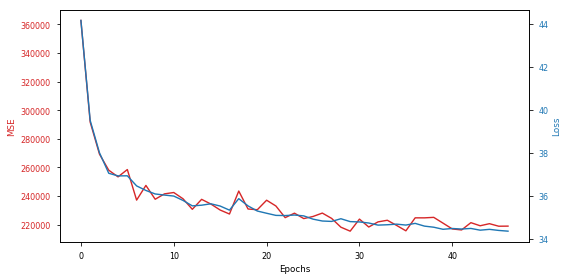

In [4]:
# save_path_aug = "./results/mnist/test1/avae_aug_noopt_l32"
save_path_noaug = "./results/mnist/test1/avae_none_noopt_l32"

# checkpoint_aug = torch.load(save_path_aug + "/best_ckpt.pth")
checkpoint_noaug = torch.load(save_path_noaug + "/best_ckpt.pth")

# fig = plt.figure(figsize=(8, 4))
# plt.plot(range(len(checkpoint_noaug['results']['val_mse'])), checkpoint_noaug['results']['val_mse'], label='mse')
# plt.plot(range(len(checkpoint_noaug['results']['val_mse'])), checkpoint_noaug['results']['val_loss'], label='loss')
# plt.title("Validation No aug over training")
# plt.xlabel("Epochs")
# plt.ylabel("Validation MSE / loss")
# plt.legend()
# plt.show()


fig, ax1 = plt.subplots(figsize=(8, 4))
color = "tab:red"
ax1.set_xlabel("Epochs")
ax1.set_ylabel("MSE", color=color)
ax1.plot(
    range(len(checkpoint_noaug["results"]["val_mse"])),
    checkpoint_noaug["results"]["val_mse"],
    color=color,
)
ax1.tick_params(axis="y", labelcolor=color)
ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("Loss", color=color)  # we already handled the x-label with ax1
ax2.plot(
    range(len(checkpoint_noaug["results"]["val_mse"])),
    checkpoint_noaug["results"]["val_loss"],
    color=color,
)
ax2.tick_params(axis="y", labelcolor=color)
fig.tight_layout()
plt.show()


# fig, ax1 = plt.subplots(figsize=(8, 4))
# color = "tab:red"
# ax1.set_xlabel("Epochs")
# ax1.set_ylabel("MSE", color=color)
# ax1.plot(
#     range(len(checkpoint_aug["results"]["val_mse"])),
#     checkpoint_aug["results"]["val_mse"],
#     color=color,
# )
# ax1.tick_params(axis="y", labelcolor=color)
# ax2 = ax1.twinx()
# color = "tab:blue"
# ax2.set_ylabel("Loss", color=color)  # we already handled the x-label with ax1
# ax2.plot(
#     range(len(checkpoint_aug["results"]["val_mse"])),
#     checkpoint_aug["results"]["val_loss"],
#     color=color,
# )
# ax2.tick_params(axis="y", labelcolor=color)
# fig.tight_layout()
# plt.show()


# fig = plt.figure(figsize=(8, 4))
# plt.plot(range(len(checkpoint_aug['results'])), checkpoint_aug['results']['val_loss'], label='mse')
# plt.plot(range(len(checkpoint_noaug['results'])), checkpoint_aug['results']['val_mse'], label='loss')
# plt.title("Validation aug over training")
# plt.xlabel("Epochs")
# plt.ylabel("Validation mse/loss")
# plt.legend()
# plt.show()

## Look at some examples

In [5]:
def plot_recon(batch, model, nsamples=4, voxel_threshold=0.5):
    x = batch["data"].to(device)[:nsamples, :, :].unsqueeze(1)
    recon_x = model(x, deterministic=True)["recon_x"]
    x, recon_x = x.squeeze(), recon_x.squeeze()
    nrows, ncols = nsamples, 2
    fig = plt.figure(figsize=(8, 3 * nsamples))
    for idx in range(0, x.size(0), 1):
        ax = fig.add_subplot(nrows, ncols, 2 * idx + 1)
        print(x[idx, :, :].min().item(), x[idx, :, :].max().item(), x[idx, :, :].mean().item())
        ax.imshow(x[idx, :, :].detach().cpu().numpy())
        ax.axis("off")

        ax = fig.add_subplot(nrows, ncols, 2 * idx + 2)
        print(recon_x[idx, :, :].min().item(), recon_x[idx, :, :].max().item(), recon_x[idx, :, :].mean().item())
        ax.imshow(recon_x[idx, :, :].detach().cpu().numpy())
        ax.axis("off")

0.0 1.0 0.032475490123033524
2.2537577024195343e-05 0.8790060877799988 0.045641642063856125
0.0 1.0 0.03806617483496666
1.432800399925327e-05 0.8528842926025391 0.04926450550556183
0.0 1.0 0.053279414772987366
1.5478824934689328e-05 0.9895349144935608 0.051911987364292145
0.0 1.0 0.07664459943771362
9.88800275081303e-06 0.9800845384597778 0.07781270891427994


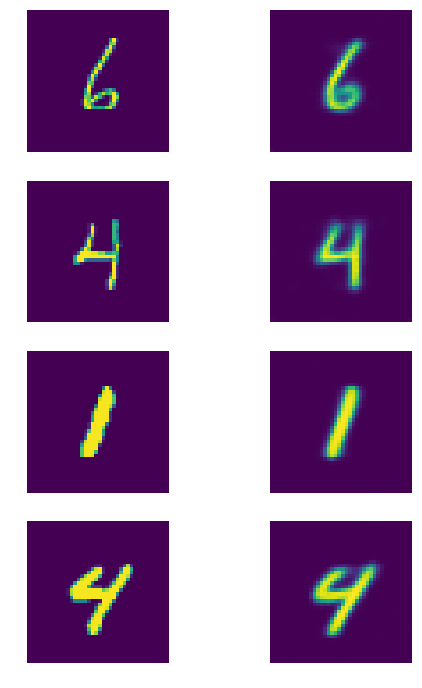

In [6]:
data_path = "./data/"
trainset = TransformedMNIST(data_path, transform_type="none", train=True)
valset = TransformedMNIST(data_path, transform_type="none", train=False)
train_loader = DataLoader(
    trainset, batch_size=32, num_workers=1, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    valset, batch_size=32, num_workers=1, pin_memory=True, shuffle=False
)

model = AVAE2d(VAE=VAE2d(latent_size=32), opt_method="none").to(device)
save_path = "./results/mnist/test1/avae_none_noopt_l32"
checkpoint = torch.load(save_path + "/best_ckpt.pth")
model.load_state_dict(checkpoint["model"])

batch = next(iter(train_loader))
plot_recon(batch, model, nsamples=4)

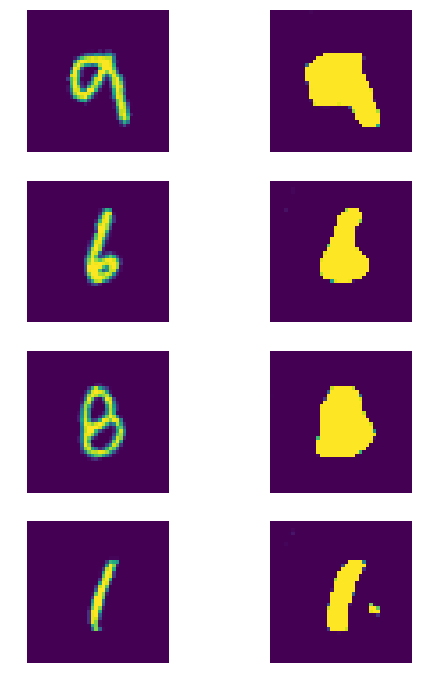

In [9]:
data_path = "./data/"
trainset = TransformedMNIST(data_path, transform_type="rand_rot", train=True)
valset = TransformedMNIST(data_path, transform_type="rand_rot", train=False)
train_loader = DataLoader(
    trainset, batch_size=32, num_workers=1, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    valset, batch_size=32, num_workers=1, pin_memory=True, shuffle=False
)

model = AVAE2d(VAE=VAE2d(latent_size=32), opt_method="none").to(device)
save_path = "./results/mnist/test1/avae_none_noopt_l32"
checkpoint = torch.load(save_path + "/best_ckpt.pth")
model.load_state_dict(checkpoint["model"])

batch = next(iter(train_loader))
plot_recon(batch, model, nsamples=4)

In [8]:
data_path = "./data/"
trainset = TransformedMNIST(data_path, transform_type="rand_rot", train=True)
valset = TransformedMNIST(data_path, transform_type="rand_rot", train=False)
train_loader = DataLoader(
    trainset, batch_size=32, num_workers=1, pin_memory=True, shuffle=True
)
val_loader = DataLoader(
    valset, batch_size=32, num_workers=1, pin_memory=True, shuffle=False
)

save_path_aug = "./results/mnist/test1/avae_aug_noopt_l32"
checkpoint_aug = torch.load(save_path_aug + "/best_ckpt.pth")
model = AVAE2d(VAE=VAE2d(latent_size=32), opt_method="none").to(device)
model.load_state_dict(checkpoint_aug["model"])

batch = next(iter(train_loader))
plot_recon(batch, model, nsamples=4)

RuntimeError: Error(s) in loading state_dict for AVAE2d:
	Missing key(s) in state_dict: "VAE.fc_logvar.weight", "VAE.fc_logvar.bias". 

## Is MSE lower on augmented or unaugmented data?

In [11]:
save_path_aug = "./results/mnist/test1/avae_aug_noopt_l"
save_path_noaug = "./results/mnist/test1/avae_none_noopt_l"
results = pd.DataFrame()

for i in range(10):
    checkpoint_noaug = torch.load(save_path_aug + "/" + str(i) + "_ckpt.pth")
    checkpoint_90aug = torch.load(save_path_noaug + "/" + str(i) + "_ckpt.pth")
    results = results.append(
        {
            "epoch": checkpoint_noaug["epoch"],
            "noaug_mse": checkpoint_noaug["val_mse"],
            "90aug_mse": checkpoint_90aug["val_mse"],
        },
        ignore_index=True,
    )

fig = plt.figure(figsize=(8, 4))
plt.plot(results["epoch"], results["noaug_mse"], label="No Augmentation")
plt.plot(results["epoch"], results["90aug_mse"], label="With Augmentation")
plt.title("Validation MSE over training")
plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './results/mnist/test1/avae_aug_noopt_l/0_ckpt.pth'

dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'results'])
-712168.969
52029454208.0
dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'results'])
-716151.4201
52033821328.0
dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'results'])
-718476.5951
52030500736.0
dict_keys(['model', 'val_loss', 'val_mse', 'epoch', 'data_ap_list', 'model_ap_list', 'results'])
-719303.8374
52026869672.0


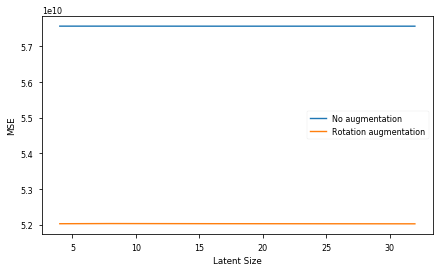

In [10]:
save_path_aug = "./results/mnist/test1/avae_aug_noopt_l"
save_path_noaug = "./results/mnist/test1/avae_none_noopt_l"
results = pd.DataFrame()

for i in [4, 8, 16, 32]:
    checkpoint_aug = torch.load(save_path_aug + str(i) + "/best_ckpt.pth")
    print(checkpoint_aug.keys())
    print(checkpoint_aug["val_loss"])
    print(checkpoint_aug["val_mse"])

    checkpoint_noaug = torch.load(save_path_noaug + str(i) + "/best_ckpt.pth")
    results = results.append(
        {
            "latent_size": i,
            "noaug_mse": checkpoint_noaug["val_mse"],
            "aug_mse": checkpoint_aug["val_mse"],
        },
        ignore_index=True,
    )

fig = plt.figure(figsize=(7, 4))
plt.plot(results["latent_size"], results["noaug_mse"], label="No augmentation")
plt.plot(results["latent_size"], results["aug_mse"], label="Rotation augmentation")
plt.xlabel("Latent Size")
plt.ylabel("MSE")
plt.legend()
plt.savefig("plots/mnist_mse_aug.eps", format="eps")
plt.show()